# Graph Convolutional Network (GCN) on the CORA citation dataset

> This demo explains how to do node classification using the StellarGraph library. [See all other demos](../../README.md).

[The StellarGraph library](https://github.com/stellargraph/stellargraph) supports many deep machine learning (ML) algorithms on [graphs](https://en.wikipedia.org/wiki/Graph_\(discrete_mathematics\)). In this notebook, we'll be training a model to predict the class or label of a node, sometimes called node classification or even node attribute inference.

There's two necessary parts to be able to do this task:

- a graph: this notebook uses the Cora dataset from <https://linqs.soe.ucsc.edu/data>. It consists of academic publications as the nodes and the citations between them as the links: if paper A cites paper B, then there's an edge from A to B. The nodes are classified into one of seven subjects, and it's this that our model will learn to predict.
- an algorithm: this notebook uses a Graph Convolution Network (GCN) [1]. The core of the GCN neural network model is a "graph convolution" layer, which is similar to a conventional dense layer, except incorporating the graph adjacency matrix to be able to use information about a node's connections.

The notebook walks through three sections:

1. **Data preparation** using [Pandas](https://pandas.pydata.org) and [scikit-learn](https://scikit-learn.org/): loading the graph from CSV files, doing some basic introspection, and splitting it into train, test and validation splits for ML
2. **Creating the GCN layers** and data input using [StellarGraph](https://github.com/stellargraph/stellargraph)
3. **Training and evaluating** the model using [TensorFlow Keras](https://www.tensorflow.org/guide/keras), Pandas and scikit-learn

Notably, only section 2 needs StellarGraph: section 1 and section 3 are driven by the existing flexible functionality in common and popular data science libraries. Most of the algorithms supported by StellarGraph follow this pattern, where the custom StellarGraph functionality integrates smoothly with the conventional data science work-flow.

> StellarGraph supports [other algorithms for doing node classification](../README.md), as well as many [other tasks](../../README.md).

[1]: [Graph Convolutional Networks (GCN): Semi-Supervised Classification with Graph Convolutional Networks](https://github.com/tkipf/gcn). Thomas N. Kipf, Max Welling.
International Conference on Learning Representations (ICLR), 2017

The first step is to import the Python libraries that we'll need.

In [1]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Data Preparation

### Loading the CORA network

We can create retrieve a `StellarGraph` graph object representing this Cora dataset using [the `Cora` loader](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.datasets.datasets.Cora) from [the `datasets` submodule](https://stellargraph.readthedocs.io/en/stable/api.html#module-stellargraph.datasets.datasets). It also provides us with the ground-truth node subjects. This function is implemented using Pandas, see [the "Loading data into StellarGraph from Pandas" notebook](../../basics/loading-pandas.ipynb) for details.

In [2]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

The `info` method can help us verify that our loaded graph matches the description:

In [3]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]


We aim to train a graph-ML model that will predict the "subject" attribute on the nodes. These subjects are one of 7 categories, with some categories more common than others:

In [4]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use [scikit-learn's `train_test_split` function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to do this.

Here we're taking 140 node labels for training, 500 for validation, and the rest for testing.

In [5]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

Note using stratified sampling gives the following counts:

In [6]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,42
Probabilistic_Methods,22
Genetic_Algorithms,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion we can use [the `LabelBinarizer` transform](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) from scikit-learn. Another option would be [the `pandas.get_dummies` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html), but the scikit-learn transform allows us to do the inverse transform easily later in the notebook, to interpret the predictions.

In [7]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero. These numeric attributes have been automatically included in the `StellarGraph` instance `G`, and so we do not have to do any further conversion.

## 2. Creating the GCN layers

A machine learning model in StellarGraph consists of a pair of items:

- the layers themselves, such as graph convolution, [dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) and even [conventional dense layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
- a data generator to convert the core graph structure and node features into a format that can be fed into the Keras model for training or prediction

GCN is a full-batch model and we're doing node classification here, which means [the `FullBatchNodeGenerator` class](https://stellargraph.readthedocs.io/en/latest/api.html#stellargraph.mapper.FullBatchNodeGenerator) is the appropriate generator for our task. StellarGraph has many generators in order to support all [its many models and tasks](../../README.md).

Specifying the `method='gcn'` argument to the `FullBatchNodeGenerator` means it will yield data appropriate for the GCN algorithm specifically, by using the [normalized graph Laplacian matrix](https://en.wikipedia.org/wiki/Laplacian_matrix#Symmetric_normalized_Laplacian) to capture the graph structure.

In [8]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


A generator just encodes the information required to produce the model inputs. Calling [the `flow` method](https://stellargraph.readthedocs.io/en/latest/api.html#stellargraph.mapper.FullBatchNodeGenerator.flow) with a set of nodes and their true labels produces an object that can be used to train the model, on those nodes and labels that were specified. We created a training set above, so that's what we're going to use here.

In [9]:
train_gen = generator.flow(train_subjects.index, train_targets)

Now we can specify our machine learning model by building a stack of layers, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use two GCN layers with 16-dimensional hidden node features at each layer.
 * `activations` is a list of activations applied to each layer's output
 * `dropout=0.5` specifies a 50% dropout at each layer. 
 
The model can be constructed using [StellarGraph's `GCN` class](https://stellargraph.readthedocs.io/en/latest/api.html#stellargraph.layer.gcn.GCN), which packages up the creation of a stack of [graph convolution](https://stellargraph.readthedocs.io/en/latest/api.html#stellargraph.layer.gcn.GraphConvolution) and [dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers.

In [10]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

To create a Keras model we now expose the input and output tensors of the GCN model for node prediction, via the `GCN.build` method:

In [11]:
x_inp, x_out = gcn.build()

Finally we add a Keras `Dense` layer to use the node embeddings to predict the 7 categories. This is a conventional approach to a classification task, using a softmax activation to ensure that the outputs for each input node will be a vector of "probabilities", where every value is between 0 and 1, and the whole vector sums to 1; the predicted class is the element with the highest value.

In [12]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

## 3. Training and evaluating

### Training the model

Now let's create the actual [Keras model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) with the input tensors `x_inp` and output tensors being the predictions `predictions` from the final dense layer. Our task is a categorical prediction task, so a categorical cross-entropy loss function is appropriate. Even though we're doing graph ML with StellarGraph, we're still working with conventional Keras prediction values, so we can use [the loss function from Keras](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy) directly.

In [13]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

As we're training the model, we'll want to also keep track of its generalisation performance on the validation set, which means creating another data generator, using our `FullBatchNodeGenerator` we created above.

In [14]:
val_gen = generator.flow(val_subjects.index, val_targets)

We can directly use more functionality offered by Keras to perform [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) (if validation accuracy stops improving) and [best model checkpoint saving](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) on our graph ML model.

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")

# (patience is the number of epochs to wait before early stopping in case of no further improvement)
es_callback = EarlyStopping(monitor="val_acc", patience=15)
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

We've now set up our model layers, our training data, our validation data and even our training callbacks, so we can now train the model using [the model's `fit` method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit). Like most things in this section, this is all built into Keras.

In [16]:
history = model.fit(
    train_gen,
    epochs=40,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

  ['...']
  ['...']
Train for 1 steps, validate for 1 steps
Epoch 1/40
1/1 - 1s - loss: 1.9616 - acc: 0.1500 - val_loss: 1.8779 - val_acc: 0.3060
Epoch 2/40
1/1 - 0s - loss: 1.8508 - acc: 0.3571 - val_loss: 1.8210 - val_acc: 0.3020
Epoch 3/40
1/1 - 0s - loss: 1.8124 - acc: 0.3214 - val_loss: 1.7753 - val_acc: 0.3020
Epoch 4/40
1/1 - 0s - loss: 1.7336 - acc: 0.3143 - val_loss: 1.7250 - val_acc: 0.3040
Epoch 5/40
1/1 - 0s - loss: 1.6460 - acc: 0.3214 - val_loss: 1.6665 - val_acc: 0.3100
Epoch 6/40
1/1 - 0s - loss: 1.5724 - acc: 0.3500 - val_loss: 1.6016 - val_acc: 0.3180
Epoch 7/40
1/1 - 0s - loss: 1.4888 - acc: 0.4071 - val_loss: 1.5410 - val_acc: 0.3800
Epoch 8/40
1/1 - 0s - loss: 1.4102 - acc: 0.4786 - val_loss: 1.4851 - val_acc: 0.4520
Epoch 9/40
1/1 - 0s - loss: 1.3416 - acc: 0.5071 - val_loss: 1.4347 - val_acc: 0.4680
Epoch 10/40
1/1 - 0s - loss: 1.2653 - acc: 0.5357 - val_loss: 1.3899 - val_acc: 0.4860
Epoch 11/40
1/1 - 0s - loss: 1.2396 - acc: 0.6000 - val_loss: 1.3515 - val_acc:

Plot the training history, to view how the loss function decreases and accuracy increases (hopefully!) over the training epochs:

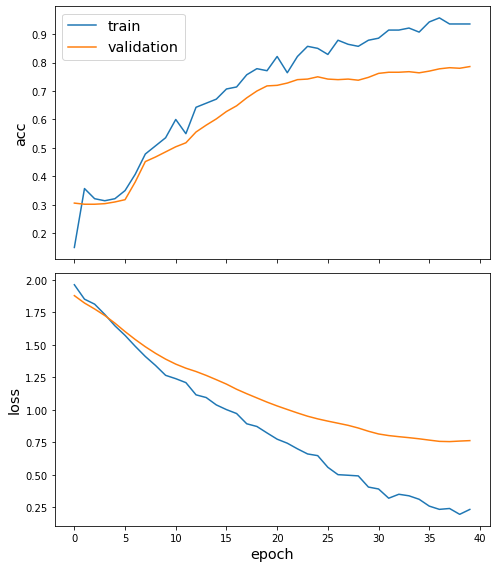

In [17]:
sg.utils.plot_history(history)

Reload the saved weights of the best model found during the training (according to validation accuracy)

In [18]:
model.load_weights("logs/best_model.h5")

Evaluate the best model on the test set. We again create the data required for this using the `flow` method on our `FullBatchNodeGenerator` from above, and can use [the model's `evaluate` method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate) to compute the metric values for the trained model.

In [19]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [20]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ['...']
1/1 [==============================] - 0s 11ms/step - loss: 0.7418 - acc: 0.7838

Test Set Metrics:
	loss: 0.7418
	acc: 0.7838


### Making predictions with the model

Now let's get the predictions for all nodes. You're probably getting used to it by now, but we use our `FullBatchNodeGenerator` to create the input required and then use [one of the model's methods: `predict`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict). This time we _don't_ provide the labels to `flow`, and instead just the nodes, because we're trying to predict these classes without knowing them.

In [21]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specifcation to turn these values back to the original categories.

Note that for full-batch methods the batch size is 1 and the predictions have shape $(1, N_{nodes}, N_{classes})$ so we we remove the batch dimension to obtain predictions of shape $(N_{nodes}, N_{classes})$ using the NumPy `squeeze` method.

In [22]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

Let's have a look at a few predictions after training the model:

In [23]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Case_Based,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


### Node embeddings

In addition to just predicting the node class, it can be useful to get a more detailed picture of what information the model has learnt about the nodes and their neighbourhoods. In this case, this means an embedding of the node (also called a "representation") into a latent vector space that captures that information, and it comes in the form of either a look-up table mapping node to a vector of numbers, or a neural network that produces those vectors. For GCN, we're going to be using the second option, using the last graph convolution layer of the GCN model (called `x_out` above), before we applied the prediction layer.

We can visualise these embeddings as points on a plot, colored by their true subject labels. If the model has learned useful information about the nodes basedon their class, we expect to see nice clusters of papers in the node embedding space, with papers of the same subject belonging to the same cluster.

To create a model that computes node embeddings, we use the same input tensors (`x_inp`) as the prediction model above, and just swap the output tensor to the GCN one (`x_out`) instead of the prediction layer. These tensors are connected to the same layers and weights that we trained when training the predictions above, and so we're only using this model to compute/"predict" the node embedding vectors. Similar to doing predictions for every node, we will compute embeddings for every node using the `all_gen` data.

In [24]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [25]:
emb = embedding_model.predict(all_gen)
emb.shape

(1, 2708, 16)

The last GCN layer had output dimension 16, meaning the each embedding consists of 16 numbers. Plotting this directly would require a 16 dimensional plot, which is hard for humans to visualise, so instead we can first project these vectors down to just 2 numbers, making vectors of dimension 2 that can be plotted on a normal 2D scatter plot.

There's many tools for [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) task, many of which are offered by scikit-learn. Two of the more common ones are [principal component analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) (which is linear) and [t-distributed Stochastic Neighbor Embedding (t-SNE or TSNE)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (non-linear). t-SNE is slower but typically gives nicer results for plotting.

In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = TSNE  # or PCA

Note that the embeddings from the GCN model have a batch dimension of 1 so we `squeeze` this to get a matrix of $N_{nodes} \times N_{emb}$.

In [27]:
X = emb.squeeze(0)
X.shape

(2708, 16)

We've thus prepared our high-dimension embeddings and chosen our dimension-reduction transform, so we now compute the reduced vectors, as two columns of the new values.

In [28]:
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

(2708, 2)

The `X_reduced` values contains a pair of numbers for each node, in the same order as the `node_subjects` Series of ground-truth labels (because that's how `all_gen` was created). This is enough to do a scatter plot of the nodes, with colors. We can let matplotlib compute the colors by mapping the subjects to integers 0, 1, ..., 6, using [Pandas's support for categorical data](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html).

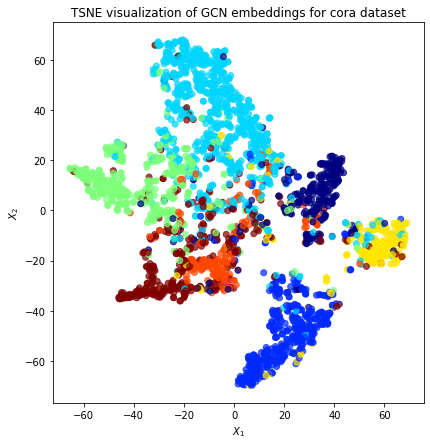

In [29]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for cora dataset",
)

## Conclusion

This notebook gave an example using the GCN algorithm to predict the class of nodes. Specifically, the subject of an academic paper in the Cora dataset. Our model used the graph structure of the dataset, in the form of citation links between papers, as well as the 1433-dimensional feature vectors associated with each paper. Once we trained a model for prediction, we could both predict the classes of nodes, and use those weights to compute vector embeddings for nodes.

The example first prepared the data using common data science libraries, then built a TensorFlow Keras model and data generator with [the StellarGraph library](https://github.com/stellargraph/stellargraph) and finally trained and evaluated it using TensorFlow and other libraries.

StellarGraph includes [other algorithms for node classification](../README.md) and [algorithms and demos for other tasks](../../README.md). Most can be applied with the same basic structure as this GCN demo.